# **Adaptive RAG**
すべてのクエリを同じ方法で処理するのではなく、各クエリタイプに最適な戦略を選択します。

具体的にはシステムがクエリを分析し、次の２つの内、最適な処理方法を決定します。
- Self-corrective RAG：インデックス化されたデータを使用して回答できる質問の場合。
- ウェブ検索：インデックスにない情報を必要とする質問の場合。

## Self-corrective RAG とは？

Self-corrective RAG とは、自己修正機構を組み込んだ手法です。通常のRAGでは、外部データから取得した情報をもとに初期の回答を生成しますが、Self-corrective RAG では以下のプロセスが追加されます：

1. **初期生成**  
   モデルが外部情報を利用して初期の回答を生成します。

2. **自己評価と誤り検出**  
   生成された回答をモデル自身(self)が評価し、誤りや不十分な点を検出します。

3. **再取得と修正**  
   検出された問題を補うため、再度情報検索を行い、取得した情報を基に回答を修正・改善します。

<!-- ![graph of Adaptive RAG](https://imgur.com/906QtPJ.png) -->

# 評価用データの準備

In [73]:
# from datasets import load_dataset
# ds = load_dataset("allganize/RAG-Evaluation-Dataset-JA")

In [74]:
# import pandas as pd
# df = ds['test'].to_pandas()
# df.head(3)

In [88]:
# eval_df = df[df['target_file_name'] == 'kaisetsushiryou_2024.pdf']
# eval_df = eval_df[['question', 'target_answer', 'target_page_no']]
# eval_df.to_csv('../data/eval_data.csv', index=False)

import pandas as pd
eval_df = pd.read_csv('../data/eval_data.csv')
eval_df.head(3)

,question,target_answer,target_page_no
0,オープンイノベーション促進税制において、スタートアップ企業の株式取得に対する税制優遇措置は、...,オープンイノベーション促進税制の下で、新規発行株式の取得は「新規出資型」として分類され、発行...,13
1,イノベーション拠点税制における所得控除について、控除対象となる研究開発活動に関して具体的にど...,イノベーション拠点税制における所得控除の対象となるためには、企業が主に「国内で」「自ら」開発...,16
2,「カーブアウト加速等支援事業」の主な目的は何ですか？,事業会社に蓄積されている技術を活用し、新たな会社を立ち上げた者や立ち上げる意思を持つ者に研究...,21


In [76]:
print(len(eval_df))

7


In [2]:
!uv pip uninstall -q pydantic==2.10
!uv pip install -q pydantic==2.9.0 # for PydanticUndefinedAnnotation: name 'SafetySetting' is not defined


# API KEYの準備

In [32]:
import os
from dotenv import load_dotenv
load_dotenv()

# # for web search
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
# # for llm
# os.environ["OPENAI_API_KEY"]  = os.getenv('OPENAI_API_KEY') # 一回の実行で1000円くらい取られます。

# VERTEXAI用の設定
import vertexai
import google.generativeai as genai

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.expanduser("~/.config/gcloud/application_default_credentials.json")
vertexai.init(project=os.getenv("gcp_project_id"), location="us-central1")

# load llm
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(
    model_name="gemini-2.0-flash-exp",
    project=os.getenv("gcp_project_id"),
    location="us-central1",
    temperature=0
)

In [ ]:
# huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks... To disable this warning, you can either: - Avoid using tokenizers before the fork if possible - Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
os.environ["TOKENIZERS_PARALLELISM"] = "true" # 警告対策　tokenizersライブラリの並列処理を明示的にON 

# load embedding model
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-base",
    encode_kwargs={"normalize_embeddings": True}
)

In [ ]:
# # load data
# from langchain_community.document_loaders import PyPDFLoader
# loader = PyPDFLoader("../data/pdf/57_public_スタートアップ育成に向けた政府の取組_file_name=kaisetsushiryou_2024.pdf")
# documents = loader.load()

# # split documents
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
# documents = text_splitter.split_documents(documents)

# from langchain.vectorstores import FAISS

# # Create vectorstore
# vectorstore = FAISS.from_documents(documents, embeddings)

# # Save locally
# vectorstore.save_local("../data/db/faiss_index") # モデルが変わると次元が変わるので作り直しが必要

# 先に作っておいたデータベースのロード

In [19]:
# Load from local file
from langchain.vectorstores import FAISS
vectorstore = FAISS.load_local("../data/db/faiss_index", embeddings, allow_dangerous_deserialization=True) # これはpickleによるデシリアライゼーションの安全性に関する警告であり、自作のDBなど信頼できるソースからのファイルであれば True で問題ありません
# create retriever
retriever = vectorstore.as_retriever()

## メモ：Pydantic基本構造

- BaseModel
    - データクラスを簡単に定義するためのPydantic基本クラス
    - 自動的な型チェックとバリデーション機能を提供

```
class User(BaseModel):
    name: str
    age: int
```

- Field
    - フィールドの詳細設定を行うためのクラス
    - バリデーションルール、デフォルト値、制約などを設定

```
class User(BaseModel):
    name: str = Field(..., min_length=2)  # nameフィールドは文字列で必須で最小２文字という意味。... は必須を表す
    age: int = Field(ge=0)     # ageフィールドは必須ではないが入れるなら0以上（ge: greater than or equal）
```

**使用例**
# 使用例
user1 = User(name="太郎", age=20)  # OK
user2 = User(name="太郎")  # エラー: ageは必須（defaultがないため）
user3 = User(name="太郎", age=-1)  # エラー: ageは0以上である必要がある

Pydanticの特徴：

1. 自動型変換：

    - age="20" → age=20 （文字列から整数に変換）
    - age=20.5 → age=20 （小数から整数に変換）
    - 
2. バリデーションエラー：

    - 整数に変換できない値（例：age="ねこ"）
    - 制約に違反する値（例：-1）


``` 
from typing import Literal # あまりみない型ヒントだけど、、、
```

Literal型では：
  - 整数、浮動小数点数
  - 文字列
  - 真偽値
これらの組み合わせのいずれも使用可能です。

## **質問ルーター**
質問ルーターは、クエリに対して、

- 内部インデックスを使用して回答すべきか
- ウェブ検索を通じて回答すべきか
  
を決定します。

トピックに基づいてプロンプトを変更してください。

In [ ]:
# create question router

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# define a data class
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    ) # datasourceフィールドが必須で["vectorstore", "web_search"]のうちどちらかが入っていないとエラーと言う定義

# LLM with function call
structured_llm_router = llm.with_structured_output(RouteQuery, method="function_calling") # Response typeが RouteQuery クラスになる


In [21]:
# テスト実行
response = structured_llm_router.invoke("AIの最新トレンドについて教えて")

# 結果の確認
print(f"Response type: {type(response)}")
print(f"Response: {response}")

Response type: <class '__main__.RouteQuery'>
Response: datasource='web_search'


In [22]:
# Prompt (add only topics that are present in you vectorstore)
system = """You are an expert at routing a user question to either a vectorstore or web search.
The vectorstore contains information on the following topics:
- Government Initiatives for Startup Development

If the question is related to these topics, route it to the vectorstore. Otherwise, use web search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [23]:
eval_df['question'][0]

'オープンイノベーション促進税制において、スタートアップ企業の株式取得に対する税制優遇措置は、新規発行株式と発行済株式の場合でそれぞれどのように異なり、またこれらの株式取得に対する所得控除の適用条件は具体的に何か？'

In [24]:
question_router.invoke({"question": eval_df['question'][0]})

RouteQuery(datasource='vectorstore')

In [11]:
question_router.invoke({"question": "猫と犬の共通祖先の名前は"})

RouteQuery(datasource='web_search')

## **Document Grader**
ドキュメント評価者は、検索してきたドキュメントが与えられたクエリに本当に関連しているかどうかを評価します。

In [ ]:
# create grader for doc retriever
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# define a data class
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeDocuments, method="function_calling") # LLM の返す出力が GradeDocuments の形式に自動的にパースされます。


In [34]:
# Prompt for the grader
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# あなたは、検索されたドキュメントがユーザーの質問に関連しているかどうかを評価する採点者です。
# ドキュメントが質問に関連するキーワードや意味的な意味を含んでいる場合、関連していると評価します。
# ドキュメントが質問に関連しているかどうかを示すために、「はい」または「いいえ」の2値スコアを付けます。（本当にこの型で返ってくるかは保証がないので、後でチェックのために structured_llm_grader を付ける）

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader # プロンプトテンプレートと構造化出力対応の LLM をパイプライン的に連結しています。これにより、grade_prompt でフォーマットされた入力が structured_llm_grader に渡され、LLM の応答が GradeDocuments 型として出力される流れとなります。

In [35]:
# testing grader example 1
question = "猫と犬の共通祖先の名前は"
docs = retriever.invoke(question)
print(retrieval_grader.invoke({"question": question, "document": docs}))

binary_score='no'


# RAG Chain

In [36]:
# create document chain
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

template = """"
You are a helpful assistant that answers questions based on the following context.
Use the provided context to answer the question.
Context: {context}
Question: {question}
Answer:

"""

prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

In [37]:
# response
generation = rag_chain.invoke({"context": docs, "question": question})
generation

'質問に答えるための情報が提供されたドキュメントの中にありません。'

## **Hallucination Grader**
幻覚評価者は、その Answer が与えられた事実に基づいていたり、裏付けられているかどうかを確認する。
言い換えると　ハルシネーションが 'ない'、'ある' を 'yes' or 'no' で評価する

In [38]:
# create grader for hallucination
# define a data class
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations, method="function_calling")

# prompt for the grader
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='no')

## **Answer Grader**
採点者は、回答が与えられた質問に効果的に対処しているかどうかを評価します。

In [39]:
# create grader for answer
# define a data class
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer, method="function_calling")

# prompt for the grader
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='no')

# Web Search

In [40]:
# define web search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

## **Create Graph**

### **Define Graph State**

In [41]:
# define a data class for state
from typing import List, Optional
from typing_extensions import TypedDict

class GraphState(TypedDict, total=False):# total=Falseで、必須ではないフィールドも追加可能
    question: str
    generation: str
    documents: List[str]
    # 追加：評価結果や状態を格納するフィールド
    status: Optional[str]  # "useful", "not_useful", "max_retries_reached" などの状態
    retry_count: Optional[int]  # 再試行回数の追跡用

In [82]:
# define graph steps
from langchain.schema import Document
from pprint import pprint
import time 

MAX_RETRIES = 2

# all nodes return state dict
def retrieve(state):

    print("---関連文書の取得---")
    question = state["question"]

    # Retrieval
    try:
        time.sleep(1)
        documents = retriever.invoke(question)
        # Convert empty list to empty Document object if no results
        if not documents:
            documents = Document(page_content="", metadata={})
        state["documents"] = documents  # stateオブジェクトを直接変更
    except Exception as e:
        print(f"取得中のエラー: {e}")
        # Return empty Document object instead of empty list
        state["documents"] = Document(page_content="", metadata={})
    return state


def generate(state):
    print("---回答生成---")
    question = state["question"]
    documents = state["documents"]

    # RAG生成
    try:
        time.sleep(1)
        generation = rag_chain.invoke({"context": documents, "question": question})
        state["generation"] = generation  # stateオブジェクトを直接変更
    except Exception as e:
        print(f"回答生成中のエラー: {e}")
        state["generation"] = Document(page_content="", metadata={}) # stateオブジェクトを直接変更
    return state 


def grade_documents(state):
    print("---質問に対する文書の関連性を確認---")
    question = state["question"]
    documents = state["documents"]

    # Handle case where documents is a tuple
    if isinstance(documents, tuple):
        documents = [documents]

    # Score each document
    filtered_docs = []  # Create list to store filtered documents
    for d in documents:
        # Ensure we're working with Document objects
        if hasattr(d, 'page_content'):
            content = d.page_content
        else:
            content = str(d)
            
        try:
            time.sleep(1)
            score = retrieval_grader.invoke(
                {"question": question, "document": content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---評価: 文書は関連しています---")
                filtered_docs.append(d)
            else:
                print("---評価: 文書は関連していません---")
        except Exception as e:
            print(f"文書評価中のエラー: {e}")
            time.sleep(1)
            continue
    
    # If no relevant docs found, return empty Document
    if not filtered_docs:
        state["documents"] = Document(page_content="", metadata={})
    else:
        state["documents"] = filtered_docs
    return state


def web_search(state):
    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    try:
        time.sleep(1)
        docs = web_search_tool.invoke({"query": question})
        web_results = "\n".join([d["content"] for d in docs])
        web_results = Document(page_content=web_results)
        state["documents"] = web_results  # stateオブジェクトを直接変更
    except Exception as e:
        print(f"Web検索中のエラー: {e}")
        state["documents"] = Document(page_content="", metadata={})# stateオブジェクトを直接変更

    return state


# edges　return strings
def route_question(state):

    print("---ROUTE QUESTION---")
    question = state["question"]
    time.sleep(1)
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):

    print("---証拠があれば回答を生成---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---決定：すべてのドキュメントは質問に関連していない。クエリを変換する。---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---決定：回答生成---")
        return "generate"


def grade_generation_v_documents_and_question(state):

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # 再試行回数を取得（初回は 0）
    retry_count = state.get("retry_count", 0)
    if retry_count >= MAX_RETRIES:
        state["status"] = "max_retries_reached"
        return state["status"]

    try:
        # 幻覚評価実施
        time.sleep(1)
        score = hallucination_grader.invoke({"documents": documents, "generation": generation})
        grade = score.binary_score

        # 幻覚チェック結果に応じた分岐
        if grade == "yes":
            print("---決定: ハルシネーションなし---")
            print("---生成結果の妥当性評価開始---")
            try:
                time.sleep(1)
                score = answer_grader.invoke({"question": question, "generation": generation})
                grade = score.binary_score
                if grade == "yes":
                    print("---決定: 生成結果に妥当性あり---")
                    state["status"] = "useful"
                    return state["status"]
                else:
                    print("---決定: 生成結果に妥当性なし---")
                    state["retry_count"] = retry_count + 1
                    state["status"] = "not useful"
                    return state["status"]
            except Exception as e:
                print(f"回答評価中のエラー: {e}")
                state["status"] = "error"
                return state["status"]
        else:
            print("---決定: ハルシネーションあり、再試行します---")
            state["retry_count"] = retry_count + 1
            state["status"] = "not supported"
            return state["status"]
    except Exception as e:
        print(f"評価中のエラー: {e}")
        state["status"] = "error"
        return state["status"]

### **Build Graph**

In [83]:
# Build graph
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": END,
        "not useful": "generate",
        "max_retries_reached": END,
        "useful": END,
    },
)

# Compile
app = workflow.compile()
# print("```mermaid")
# print(app.get_graph().draw_mermaid())
# print("```")

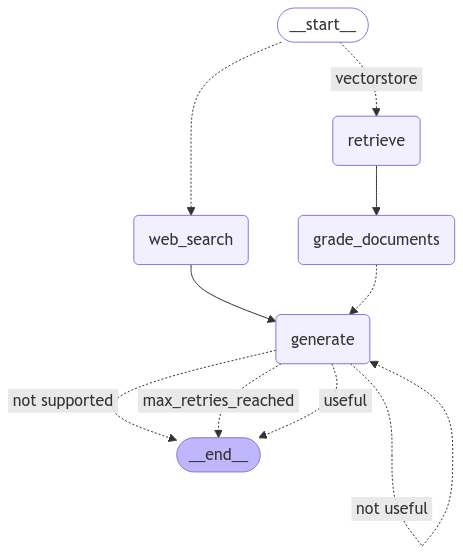

In [84]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

# test app

In [85]:
# Final generation example 1 (web search)
from pprint import pprint

inputs = {"question": "猫と犬の共通祖先の名前は"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---回答生成---
---CHECK HALLUCINATIONS---
---決定: ハルシネーションなし---
---生成結果の妥当性評価開始---
---決定: 生成結果に妥当性あり---
"Node 'generate':"
'\n---\n'
'ミアキス\n'


In [87]:
# Final generation example 2 (relevant documents)
inputs = {"question": eval_df['question'][0]}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---関連文書の取得---
"Node 'retrieve':"
'\n---\n'
---質問に対する文書の関連性を確認---
---評価: 文書は関連しています---
---評価: 文書は関連しています---
---評価: 文書は関連していません---
---評価: 文書は関連していません---
---証拠があれば回答を生成---
---決定：回答生成---
"Node 'grade_documents':"
'\n---\n'
---回答生成---
---CHECK HALLUCINATIONS---
---決定: ハルシネーションなし---
---生成結果の妥当性評価開始---
---決定: 生成結果に妥当性あり---
"Node 'generate':"
'\n---\n'
('オープンイノベーション促進税制では、スタートアップ企業の株式取得に対する税制優遇措置として、新規発行株式と発行済株式（M&A型）で以下の違いがあります。\n'
 '\n'
 '*   **対象株式**:\n'
 '    *   新規発行株式\n'
 '    *   発行済株式（50%超の取得時）\n'
 '\n'
 '*   **所得控除上限額（取得額換算）**:\n'
 '    *   新規発行株式：12.5億円/件（50億円/件）、年間125億円/社（500億円/社）\n'
 '    *   発行済株式：50億円/件（200億円/件）\n'
 '\n'
 '*   **株式取得下限額**:\n'
 '    *   新規発行株式：大企業1億円/件、中小企業1千万円/件。海外スタートアップの場合、一律5億円/件\n'
 '    *   発行済株式：5億円/件\n'
 '\n'
 '*   **所得控除**:\n'
 '    *   取得株式の25%を所得控除（共通）\n'
 '\n'
 '*   **適用条件**:\n'
 '    *   M&A型については、5年以内にスタートアップが成長投資・事業成長の要件を満たさなかった場合等には、所得控除分が一括で取り戻される。\n'
 '\n')


In [89]:
# Create Create a a new new row ro
new_row = {
    'question': '猫と犬の共通祖先の名前は？',
    'target_answer': 'ミアキス',
    'target_page_no': None
}

# Add the new row to eval_df
eval_df = pd.concat([eval_df, pd.DataFrame([new_row])], ignore_index=True)
eval_df

,question,target_answer,target_page_no
0,オープンイノベーション促進税制において、スタートアップ企業の株式取得に対する税制優遇措置は、...,オープンイノベーション促進税制の下で、新規発行株式の取得は「新規出資型」として分類され、発行...,13
1,イノベーション拠点税制における所得控除について、控除対象となる研究開発活動に関して具体的にど...,イノベーション拠点税制における所得控除の対象となるためには、企業が主に「国内で」「自ら」開発...,16
2,「カーブアウト加速等支援事業」の主な目的は何ですか？,事業会社に蓄積されている技術を活用し、新たな会社を立ち上げた者や立ち上げる意思を持つ者に研究...,21
3,グローバル・アクセラレーション・ハブの拠点がある北米の都市を全て教えてください。,グローバル・アクセラレーション・ハブの北米の拠点は、ボストン、ニューヨーク、シカゴ、オーステ...,24
4,産業革新投資機構がベンチャー・グロース・インベストメンツを通じて設立したファンドについて、資...,産業革新投資機構(JIC)は子会社であるベンチャー・グロース・インベストメンツ(VGI)を通...,32
5,スタートアップ支援資金と挑戦支援資本強化特別貸付の融資限度額と返済期間の違いに加えて、要件や...,スタートアップ支援資金は融資限度額が20億円で直接貸付、返済期間は20年以内、要件はJVCA...,33
6,宇宙戦略基金の設立と関連する技術開発テーマの具体的な支援分野について説明し、各分野間でどのよ...,宇宙戦略基金は、民間企業や大学、スタートアップ、国立研究機関に対して10年間にわたる研究開発...,38
7,猫と犬の共通祖先の名前は？,ミアキス,None


In [90]:
# Create a dataframe to store the question, context, and response
import time

outputs = []

for i, row in eval_df.iterrows():
    try:
        for output in app.stream({'question': row['question']}):
            print(f"{output=}")
            for key, value in output.items():
                if key == "generate":
                    question = value['question']
                    documents = value["documents"]
                    generation = value["generation"]
                    
                    # Ensure documents is a list and convert if needed
                    if not isinstance(documents, list):
                        if hasattr(documents, 'page_content'):
                            documents = [documents]
                        else:
                            documents = [Document(page_content=str(documents))]
                            
                    # Append the result with ragas format and evaluation results
                    outputs.append({
                        "user_input": question,
                        "retrieved_contexts": [doc.page_content for doc in documents],
                        "response": generation,
                        "reference": row['target_answer']
                    })
    except Exception as e:
        if "Quota exceeded" in str(e):
            print("生成要求のクォータ上限に達しました。後ほど再実行するか、Vertex AIのクォータ増加を申請してください。")
        else:
            print(f"エラーが発生しました: {e}")
        # クォータ超過の場合は、少し待ってから次の質問へ進むか、もしくは処理をスキップ
        time.sleep(10)


pprint(f"{outputs=}")

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---関連文書の取得---
output={'retrieve': {'question': 'オープンイノベーション促進税制において、スタートアップ企業の株式取得に対する税制優遇措置は、新規発行株式と発行済株式の場合でそれぞれどのように異なり、またこれらの株式取得に対する所得控除の適用条件は具体的に何か？', 'documents': [Document(id='e25645b3-a87d-4d5b-acd6-38f07cadb097', metadata={'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'creationdate': '2024-09-13T23:19:43+09:00', 'title': 'スタートアップ政策について', 'author': 'Windows ユーザー', 'moddate': '2024-09-13T23:19:43+09:00', 'source': '../data/pdf/57_public_スタートアップ育成に向けた政府の取組_file_name=kaisetsushiryou_2024.pdf', 'total_pages': 57, 'page': 13, 'page_label': '14'}, page_content='\uf070 国内事業会社又はその国内CVCが、オープンイノベーションにより新事業開拓・生産性向上を図ることを目的\nに、スタートアップ企業（設立10年未満の国内外の非上場企業*1、2）の株式を取得する場合、取得価額の25%\nを課税所得から控除する制度。\n*1：売上高研究開発費比率10%以上かつ赤字企業の場合、設立15年未満の企業も対象 *2：M&A型は海外スタートアップ除く\n「オープンイノベーション促進税制*」\n■ 概要\n■ スキーム・要件\n■ 実績・アピールポイント\nツール 補助金 税制 表彰 イベント その他\n支援\n対象\n起業家・\n経営者 投資家 従業員 事業会社 その他\nステージ シード ア

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


---評価: 文書は関連していません---
---証拠があれば回答を生成---
---決定：回答生成---
output={'grade_documents': {'question': 'オープンイノベーション促進税制において、スタートアップ企業の株式取得に対する税制優遇措置は、新規発行株式と発行済株式の場合でそれぞれどのように異なり、またこれらの株式取得に対する所得控除の適用条件は具体的に何か？', 'documents': [Document(id='e25645b3-a87d-4d5b-acd6-38f07cadb097', metadata={'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'creationdate': '2024-09-13T23:19:43+09:00', 'title': 'スタートアップ政策について', 'author': 'Windows ユーザー', 'moddate': '2024-09-13T23:19:43+09:00', 'source': '../data/pdf/57_public_スタートアップ育成に向けた政府の取組_file_name=kaisetsushiryou_2024.pdf', 'total_pages': 57, 'page': 13, 'page_label': '14'}, page_content='\uf070 国内事業会社又はその国内CVCが、オープンイノベーションにより新事業開拓・生産性向上を図ることを目的\nに、スタートアップ企業（設立10年未満の国内外の非上場企業*1、2）の株式を取得する場合、取得価額の25%\nを課税所得から控除する制度。\n*1：売上高研究開発費比率10%以上かつ赤字企業の場合、設立15年未満の企業も対象 *2：M&A型は海外スタートアップ除く\n「オープンイノベーション促進税制*」\n■ 概要\n■ スキーム・要件\n■ 実績・アピールポイント\nツール 補助金 税制 表彰 イベント その他\n支援\n対象\n起業家・\n経営者 投資家 従業員 事業会社 その他\nステージ シード アーリ

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


---ROUTE QUESTION TO RAG---
---関連文書の取得---
output={'retrieve': {'question': 'イノベーション拠点税制における所得控除について、控除対象となる研究開発活動に関して具体的にどのような条件が求められますか？', 'documents': [Document(id='d4ee3058-3d13-44bb-924a-cbe0cbfca2fc', metadata={'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'creationdate': '2024-09-13T23:19:43+09:00', 'title': 'スタートアップ政策について', 'author': 'Windows ユーザー', 'moddate': '2024-09-13T23:19:43+09:00', 'source': '../data/pdf/57_public_スタートアップ育成に向けた政府の取組_file_name=kaisetsushiryou_2024.pdf', 'total_pages': 57, 'page': 16, 'page_label': '17'}, page_content='\uf070 我が国のイノベーション拠点の立地競争力を強化する観点から、海外と比べて遜色ない事業環境の整備を図る\nため、国内で自ら研究開発した知的財産権（特許権、AI関連のプログラムの著作権）から生じるライセンス所\n得、譲渡所得を対象に、所得控除30％を措置する制度。\n「イノベーション拠点税制（イノベーションボックス税制）*」\n■ 概要\n■ スキーム・要件\n■ 実績・アピールポイント\nツール 補助金 税制 表彰 イベント その他\n支援\n対象\n起業家・\n経営者 投資家 従業員 事業会社 その他\nステージ シード アーリー ミドル レイター その他\n\uf070 令和６年度税制改正において、新設（令和７年度より７年間）。\n関連リンク： イノベーション拠点税制について\n： 課税所得全体\n： 本税制の対象となる所得\n特許権等\

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


---決定: 生成結果に妥当性あり---
output={'generate': {'question': 'イノベーション拠点税制における所得控除について、控除対象となる研究開発活動に関して具体的にどのような条件が求められますか？', 'documents': [Document(id='d4ee3058-3d13-44bb-924a-cbe0cbfca2fc', metadata={'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'creationdate': '2024-09-13T23:19:43+09:00', 'title': 'スタートアップ政策について', 'author': 'Windows ユーザー', 'moddate': '2024-09-13T23:19:43+09:00', 'source': '../data/pdf/57_public_スタートアップ育成に向けた政府の取組_file_name=kaisetsushiryou_2024.pdf', 'total_pages': 57, 'page': 16, 'page_label': '17'}, page_content='\uf070 我が国のイノベーション拠点の立地競争力を強化する観点から、海外と比べて遜色ない事業環境の整備を図る\nため、国内で自ら研究開発した知的財産権（特許権、AI関連のプログラムの著作権）から生じるライセンス所\n得、譲渡所得を対象に、所得控除30％を措置する制度。\n「イノベーション拠点税制（イノベーションボックス税制）*」\n■ 概要\n■ スキーム・要件\n■ 実績・アピールポイント\nツール 補助金 税制 表彰 イベント その他\n支援\n対象\n起業家・\n経営者 投資家 従業員 事業会社 その他\nステージ シード アーリー ミドル レイター その他\n\uf070 令和６年度税制改正において、新設（令和７年度より７年間）。\n関連リンク： イノベーション拠点税制について\n： 課税所得全体\n： 本税制の対象となる所得\n特許権等\n譲渡\n所得\nライセンス\n所得\n所

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota excee

---ROUTE QUESTION TO RAG---
---関連文書の取得---
output={'retrieve': {'question': '「カーブアウト加速等支援事業」の主な目的は何ですか？', 'documents': [Document(id='ccb293a4-a39f-4a02-b902-687f02c1fa5e', metadata={'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'creationdate': '2024-09-13T23:19:43+09:00', 'title': 'スタートアップ政策について', 'author': 'Windows ユーザー', 'moddate': '2024-09-13T23:19:43+09:00', 'source': '../data/pdf/57_public_スタートアップ育成に向けた政府の取組_file_name=kaisetsushiryou_2024.pdf', 'total_pages': 57, 'page': 22, 'page_label': '23'}, page_content='\uf070 日本企業では、研究開発により得た技術であって、事業化されないものの多くが消滅しており、研究開発投資\nの多くの割合を占める大企業には、イノベーションにつながり得る研究開発の成果（技術シーズ）が多く蓄積\nされていることが示唆される。\n\uf070 本事業では、事業会社に蓄積されている技術（経営戦略上コア技術に位置づけられないものや外の経営資源を\n活用した方が迅速な事業化を実現できる技術等）を活用し、新たな会社を立ち上げた者又は立ち上げる意思を\n有する者を主な対象にして、研究開発費の助成や専門家による伴走支援を行うとともに、その促進のための経\n営人材等マッチングや技術シーズの発掘等の支援を行う。\n「カーブアウト加速等支援事業」\n■ 概要\n■ スキーム・要件\n予算額 10億円\n関連リンク 経済産業省HP\n問い合わせ先\nツール 補助金 税制 表彰 イベント その他\n支援\n対象\n起業家・

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


---評価: 文書は関連しています---
---評価: 文書は関連していません---
---評価: 文書は関連していません---
---評価: 文書は関連していません---
---証拠があれば回答を生成---
---決定：回答生成---
output={'grade_documents': {'question': '「カーブアウト加速等支援事業」の主な目的は何ですか？', 'documents': [Document(id='ccb293a4-a39f-4a02-b902-687f02c1fa5e', metadata={'producer': 'Microsoft® PowerPoint® for Microsoft 365', 'creator': 'Microsoft® PowerPoint® for Microsoft 365', 'creationdate': '2024-09-13T23:19:43+09:00', 'title': 'スタートアップ政策について', 'author': 'Windows ユーザー', 'moddate': '2024-09-13T23:19:43+09:00', 'source': '../data/pdf/57_public_スタートアップ育成に向けた政府の取組_file_name=kaisetsushiryou_2024.pdf', 'total_pages': 57, 'page': 22, 'page_label': '23'}, page_content='\uf070 日本企業では、研究開発により得た技術であって、事業化されないものの多くが消滅しており、研究開発投資\nの多くの割合を占める大企業には、イノベーションにつながり得る研究開発の成果（技術シーズ）が多く蓄積\nされていることが示唆される。\n\uf070 本事業では、事業会社に蓄積されている技術（経営戦略上コア技術に位置づけられないものや外の経営資源を\n活用した方が迅速な事業化を実現できる技術等）を活用し、新たな会社を立ち上げた者又は立ち上げる意思を\n有する者を主な対象にして、研究開発費の助成や専門家による伴走支援を行うとともに、その促進のための経\n営人材等マッチングや技術シーズの発掘等の支援を行う。\n「カーブアウト加速等支援事業」\n■ 

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota excee

---CHECK HALLUCINATIONS---
---決定: ハルシネーションなし---
---生成結果の妥当性評価開始---
---決定: 生成結果に妥当性あり---
output={'generate': {'question': 'グローバル・アクセラレーション・ハブの拠点がある北米の都市を全て教えてください。', 'documents': Document(metadata={}, page_content='海外展開への近道！スタートアップ向けのハンズオンサービス、グローバルアクセラレーションハブが今年もオープン！ | 独立行政法人 日本貿易振興機構（ジェトロ）スタートアップ課のプレスリリース プレスリリース・ニュースリリース配信サービスのPR TIMES プレスリリースを受信企業登録申請 テクノロジー モバイル アプリ エンタメ ビューティー ファッション ライフスタイル ビジネス グルメ スポーツ PR TIMESのご利用について 資料をダウンロード 独立行政法人 日本貿易振興機構（ジェトロ）スタートアップ課 会社概要 フォロー 海外展開への近道！スタートアップ向けのハンズオンサービス、グローバルアクセラレーションハブが今年もオープン！ JETROスタートアップ課 2021年6月11日 15時23分 グローバルスケールを目指す日本のスタートアップを世界29カ所の拠点で全力サポート！まずはご希望の地域のエコシステム情報をチェックしてお申込みください。 日本のスタートアップのグローバル展開を世界20カ所以上でサポートしてきたジェトロ・グローバルアクセラレーションハブ。今年度は新たにオーストラリア（シドニー）とカナダ（トロント）にも開設し、各地でメンターを拡充して順次サービスを開始しています！現地エコシステムに精通した有力アクセラレーターより、海外での販路開拓、海外での資金調達などに向けて個別支援します。メンタリング・マッチングともにオンラインでの対応も可能です。コロナ禍においても世界に挑戦するスタートアップを全力でサポートします！   ■支援メニュー（すべて無料※） 1.ブリーフィング：現地のビジネス環境や最新の動向についてご説明。 2.メンタリング：成功のカギを握る事業戦略や資金調達等を専門家がアドバイス。 3.マッチング：現地パートナー企業・VC

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota excee

文書評価中のエラー: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.


Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


---評価: 文書は関連していません---
---証拠があれば回答を生成---
---決定：回答生成---
output={'grade_documents': {'question': 'スタートアップ支援資金と挑戦支援資本強化特別貸付の融資限度額と返済期間の違いに加えて、要件や利率、保証人の条件も比較して詳しく説明してください。', 'documents': Document(metadata={}, page_content='')}}
---回答生成---
---CHECK HALLUCINATIONS---
---決定: ハルシネーションあり、再試行します---
output={'generate': {'question': 'スタートアップ支援資金と挑戦支援資本強化特別貸付の融資限度額と返済期間の違いに加えて、要件や利率、保証人の条件も比較して詳しく説明してください。', 'documents': Document(metadata={}, page_content=''), 'generation': '申し訳ありません。提供されたコンテキストには、スタートアップ支援資金と挑戦支援資本強化特別貸付に関する情報が含まれていません。そのため、これらの融資制度の融資限度額、返済期間、要件、利率、保証人の条件などを比較して詳しく説明することはできません。\n'}}
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
output={'web_search': {'question': '宇宙戦略基金の設立と関連する技術開発テーマの具体的な支援分野について説明し、各分野間でどのように柔軟な移行が可能かを詳述してください。', 'documents': Document(metadata={}, page_content='これらを達成するために、本事業における各技術開発テーマの連携、分野 間連携、分野共通基盤技術の推進や枠組み間の柔軟な移行、制度環境の整 備、関係\n本事業の技術開発テーマの設定にあたっては宇宙技術戦略（「宇宙輸送」「衛星」「宇宙科学・探. 査」「分野共通技術」）で抽出された技術項目を参照する。 ○ その上で、JAXA\n「市場の拡大」、「社会課題解決

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..


---CHECK HALLUCINATIONS---


Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-experimental. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai..
Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised ResourceExhausted: 429 Quota excee

---決定: ハルシネーションなし---
---生成結果の妥当性評価開始---
---決定: 生成結果に妥当性あり---
output={'generate': {'question': '猫と犬の共通祖先の名前は？', 'documents': Document(metadata={}, page_content='クイズプラス メニューのランダムクイズから多くのクイズに挑戦できます。 クイズ一覧 クイズ検索 最新クイズ ランダムクイズ クイズリンク プロフィール X（旧Twitter） ＱＲコード クイズ検索 犬と猫の共通の祖先の名前は？（ドリアスピス、カメロケラス、ミアキス、アノマロカリス) ()の中からクイズの答えを選択 答えを見る 解答方法について （）の中から、答えを選んでください。 問題文の後ろの（）のどれか1つが正解です。 「、」が区切りになっています。 選択肢に「、」が含まれる場合は、「」で囲んであります。 問題文の後ろに（）がない場合もあります。その場合は、そのまま回答してください。 問題の正解は、この後の文章を読めばわかるようになっています。 また、 （）の何番目が正解かわかるようになっており、赤文字で表示しています 。 (黒文字の場合もあり） ただし、省略されている場合があります。 正解は、下記となります。 正解が表示されていない場合は、 ミアキス https://ja.wikipedia.org/wiki/ミアキス コメント : 0 トラックバック : 0 カテゴリ : クイズ クイズプラス クイズ314 クイズ299 クイズ631 クイズ264 クイズ232 クイズ72 クイズ542 クイズ647 クイズ364 クイズ90 クイズ70 クイズ661 クイズ612 クイズ235 クイズ363 クイズ320 クイズ49 クイズ447 クイズ523 クイズ556 クイズ638 クイズ125 クイズ290 クイズ130 クイズ481 クイズ189 クイズ502 クイズ274 クイズ348 クイズ96 クイズ340 クイズ102 クイズ592 クイズ559 クイズ582 クイズ334 クイズ248 クイズ452 クイズ43 クイズ205 クイズ690 クイズ95 クイズ564 クイズ301 クイズ132 クイズ468 クイズ18 クイズ350 クイ

In [100]:
import pandas as pd
from pprint import pprint

df = pd.DataFrame(outputs)
df.head(3)

,user_input,retrieved_contexts,response,reference
0,オープンイノベーション促進税制において、スタートアップ企業の株式取得に対する税制優遇措置は、...,[ 国内事業会社又はその国内CVCが、オープンイノベーションにより新事業開拓・生産性向上を...,オープンイノベーション促進税制では、スタートアップ企業の株式取得に対する税制優遇措置として、...,オープンイノベーション促進税制の下で、新規発行株式の取得は「新規出資型」として分類され、発行...
1,イノベーション拠点税制における所得控除について、控除対象となる研究開発活動に関して具体的にど...,[ 我が国のイノベーション拠点の立地競争力を強化する観点から、海外と比べて遜色ない事業環境...,イノベーション拠点税制における所得控除の対象となる研究開発活動に関して、以下の条件が求められ...,イノベーション拠点税制における所得控除の対象となるためには、企業が主に「国内で」「自ら」開発...
2,「カーブアウト加速等支援事業」の主な目的は何ですか？,[ 日本企業では、研究開発により得た技術であって、事業化されないものの多くが消滅しており、...,「カーブアウト加速等支援事業」の主な目的は、事業会社に蓄積されている技術（経営戦略上コア技術...,事業会社に蓄積されている技術を活用し、新たな会社を立ち上げた者や立ち上げる意思を持つ者に研究...


In [ ]:
# pprint(df.to_dict(orient="records"))

[{'reference': 'オープンイノベーション促進税制の下で、新規発行株式の取得は「新規出資型」として分類され、発行済株式（50%以上の取得）は「M&A型」として分類されます。新規出資型では、国内事業会社またはその国内CVCがスタートアップ企業の新規発行株式を取得する場合に、その取得価額の25%を課税所得から控除できます。一方、M&A型ではスタートアップの成長に資するM&Aが成長投資・事業成長の要件を満たさなかった場合、所得控除分を一括取り戻されるリスクがありますが、同様に取得価額の25%を所得控除できます。所得控除の適用条件として、新規出資型の株式取得下限額は大企業1億円、中小企業1千万円、海外スタートアップの場合一律5億円であり、M&A型では株式取得上限額が200億円/件、下限額は5億円/件です。',
  'response': 'オープンイノベーション促進税制では、スタートアップ企業の株式取得に対する税制優遇措置として、新規発行株式と発行済株式（M&A型）で以下の違いがあります。\n'
              '\n'
              '*   **対象株式**：\n'
              '    *   新規発行株式\n'
              '    *   発行済株式（50%超の取得時）\n'
              '\n'
              '*   **所得控除上限額（取得額換算）**：\n'
              '    *   新規発行株式：12.5億円/件（50億円/件）、年間125億円/社（500億円/社）\n'
              '    *   発行済株式：50億円/件（200億円/件）\n'
              '\n'
              '*   **株式取得下限額**：\n'
              '    *   新規発行株式：大企業1億円/件、中小企業1千万円/件、海外スタートアップの場合一律5億円/件\n'
              '    *   発行済株式：5億円/件\n'
              '\n'
              '*   **所得控除**：\n'
              '    *   

In [95]:
import logging
logging.disable(logging.CRITICAL)

from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness
# from ragas.metrics import Faithfulness
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_list(outputs)
evaluator_llm = LangchainLLMWrapper(llm)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness()],
    # metrics=[Faithfulness()],
    llm=evaluator_llm,
)

result # {'context_recall': 0.8519, 'faithfulness': 1.0000, 'factual_correctness': 0.6314}

Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]

{'context_recall': 0.8519, 'faithfulness': 1.0000, 'factual_correctness': 0.7150}

In [101]:
df.to_csv("../data/rag12_results.csv")